In [2]:
# Copyright 2024 Mohammed Faizan
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
# Define indices and their respective time zones
indices = {
    '^GSPC': 'USD',   # S&P 500 (USA)
    '^SPX': 'USD',    # S&P 500 (USA)
    '^IXIC': 'USD',   # NASDAQ Composite (USA)
    '^DJI': 'USD',    # Dow Jones Industrial Average (USA)
    'EEM': 'USD',     # iShares MSCI Emerging Markets ETF (USA)
    'ACWI': 'USD',    # iShares MSCI ACWI ETF (USA)
    'IEF': 'USD',     # iShares 7-10 Year Treasury Bond ETF (USA)
    'TLT': 'USD',     # iShares 20+ Year Treasury Bond ETF (USA)
    '^GDAXI': 'EUR',  # DAX Performance Index (Germany)
    '^FCHI': 'EUR',   # CAC 40 Index (France)
    '000001.SS': 'CNY',  # Shanghai Composite Index (China)
    '^HSI': 'HKD',    # Hang Seng Index (Hong Kong)
    '^AXJO': 'AUD',   # S&P/ASX 200 Index (Australia)
    '^NSEI': 'INR',   # S&P NSE Sensex Index (India)
    '^GSPTSE': 'CAD',  # S&P/TSX Composite Index (Canada)
    '^STOXX50E': 'EUR', # EURO STOXX 50 Index (Europe)
    'DX-Y.NYB': 'USD', # US Dollar Index (USA)
    'DBC': 'USD',      # Invesco DB Commodity Tracking ETF (USA)
    '^FTSE': 'GBP',    # FTSE 100 Index (UK)
    '^N225': 'JPY',    # Nikkei 225 Index (Japan)
    '^SSMI': 'CHF',    # Swiss Market Index (Switzerland)
    'S68.SI': 'SGD',   # Singapore Exchange (Singapore Dollar)
}

In [5]:
weights = {
    '^GSPC': 0.2849341505160153,
    '^SPX': 0.2849341505160153,
    '^IXIC': 0.13904406766236627,
    '^DJI': 0.06733580635221512,
    'EEM': 0.00013660798561437334,
    'ACWI': 0.00012873756669008846,
    'IEF': 5.5655105250300244e-05,
    'TLT': 7.770477096674917e-05,
    '^GDAXI': 0.009494473622946843,
    '^FCHI': 0.0162405469866196,
    '000001.SS': 0.04434918600192275,
    '^HSI': 0.016865183409181892,
    '^AXJO': 0.00974432819197176,
    '^NSEI': 0.019988365521993356,
    '^GSPTSE': 0.015615910564057308,
    '^STOXX50E': 0.029982548282990032,
    'DBC': 1.4366637718932724e-05,
    '^FTSE': 0.021862274789680232,
    '^N225': 0.02685936617017857,
    '^SSMI': 0.011868092028683554,
    'S68.SI': 0.00046847731692171925
}

In [6]:
# Getting the user input for the period and interval

def get_user_input():
    allowed_intervals = ['5m', '15m', '30m', '60m', '1d', '5d']
    interval_mapping = {
        '5m': ('5T', 50),
        '15m': ('15T', 25),
        '30m': ('30T', 25),
        '60m': ('60T', 20),
        '1d': ('1D', 15),
        '5d': ('5D', 10),
    }
    
    while True:
        interval = input(f"Enter the interval {allowed_intervals}: ")
        if interval not in allowed_intervals:
            print("Invalid interval. Please select from the allowed intervals.")
            continue
        
        period = input("Enter the period in days (e.g., '7d', '365d', '40d'): ")
        if not period.endswith('d') or not period[:-1].isdigit():
            print("Invalid period format. Please enter the period in days (e.g., '7d').")
            continue
        
        days = int(period.replace('d', ''))
        if days > 2000:
            print("The maximum number of days allowed is 2000. Please enter a valid period.")
            continue
        
        return period, interval, interval_mapping[interval]
    
period, interval, (interval_converted, ema_span) = get_user_input()

In [ ]:
# fetching the data from Yahoo Finance

adj_close_data = {}
    
for index, timezone in indices.items():
    data = yf.download(index, period=period, interval=interval)
    data.dropna(how="any", inplace=True)
        
    if data.empty:
        print(f"No data for {index}")
        continue
    adj_close_data[index] = data['Adj Close']

In [ ]:
# fetching the exchange rates

exchange_rates = {}

for index, currency in indices.items():
    if currency != 'USD':
        exchange_rate_data = yf.download(f'{currency}=X', period='2200d', interval='1d')
            
        if exchange_rate_data.empty:
            print(f"No data for {index}")
            continue
        exchange_rates[currency] = exchange_rate_data['Adj Close']

In [ ]:
# Convert non-USD prices to USD

USD_Convdata = {}
for index, currency in indices.items():
    if currency != 'USD':
        exchange_rate = exchange_rates[currency]
        # Ensure the index of exchange_rate is in datetime.date format
        exchange_rate.index = pd.to_datetime(exchange_rate.index).date
        # Forward-fill missing exchange rates
        exchange_rate = exchange_rate.ffill()
        converted_data = adj_close_data[index].copy()
        for date in converted_data.index:
            date_only = date.date()
            if date_only in exchange_rate.index:
                rate = exchange_rate.loc[date_only]
                converted_data.loc[date] /= rate
            else:
                print(f"No exchange rate data for {currency} on {date_only}, using the most recent available rate.")
                # Use the most recent available rate
                rate = exchange_rate.loc[:date_only].iloc[-1]
                converted_data.loc[date] /= rate
        USD_Convdata[index] = converted_data
    else:
        USD_Convdata[index] = adj_close_data[index]

In [10]:
# Calculate median and IQR for each index
medians_iqrs = {}
for index, data in USD_Convdata.items():
    median = data.median()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    medians_iqrs[index] = (median, iqr)

# Apply robust scaling
scaled_data = {}
for index, data in USD_Convdata.items():
    median, iqr = medians_iqrs[index]
    scaled_data[index] = (data - median) / iqr

In [11]:
# Timezone conversion to New York time

def convert_timezone(data, to_timezone='America/New_York'):
    try:
        data.index = data.index.tz_localize('UTC').tz_convert(to_timezone)
    except TypeError:
        data.index = data.index.tz_convert(to_timezone)
    return data

for index in scaled_data:
        scaled_data[index] = convert_timezone(scaled_data[index])

In [12]:
# Combine the scaled data into a single dataset

def create_combined_dataset(adj_close_data, interval):
    # Create a unified time range across all dates
    all_dates = pd.date_range(
        start=min(min(data.index.date) for data in adj_close_data.values()),
        end=max(max(data.index.date) for data in adj_close_data.values()),
        freq='B'
    )

    if interval in ['1d', '5d']:
        # Create a DataFrame for all dates
        combined_data = pd.DataFrame(index=all_dates)

        # For each index, align and fill the data
        for idx, data in adj_close_data.items():
            data = data.reset_index()

            # Handle different cases of index column names
            date_col = 'Date' if 'Date' in data.columns else data.columns[0]
            data[date_col] = pd.to_datetime(data[date_col]).dt.date  # Ensure 'Date' is datetime
            data.set_index(date_col, inplace=True)

            daily_data = data.reindex(combined_data.index, fill_value=float('nan'))
            combined_data[idx] = daily_data['Adj Close']  # Adding Adjusted Close prices

        combined_data.index = pd.to_datetime(combined_data.index)
        combined_data.index.name = 'Datetime'
    else:
        # Create a MultiIndex DataFrame for all dates and times
        time_range = pd.date_range(start='00:00', end='23:59', freq=interval).time
        index = pd.MultiIndex.from_product([all_dates, time_range], names=['Date', 'Time'])
        combined_data = pd.DataFrame(index=index)

        # For each index, align and fill the data
        for idx, data in adj_close_data.items():
            data = data.reset_index()

            # Handle different cases of index column names
            datetime_col = 'Datetime' if 'Datetime' in data.columns else data.columns[0]
            data['Date'] = pd.to_datetime(data[datetime_col]).dt.date  # Extract the date
            data['Time'] = pd.to_datetime(data[datetime_col]).dt.floor(interval).dt.time  # Align to specified intervals

            data.set_index(['Date', 'Time'], inplace=True)

            daily_data = data.reindex(combined_data.index, fill_value=float('nan'))
            combined_data[idx] = daily_data['Adj Close']  # Adding Adjusted Close prices

        combined_data.index = combined_data.index.to_frame().apply(lambda row: pd.Timestamp.combine(row['Date'], row['Time']), axis=1)
        combined_data.index = combined_data.index.tz_localize('America/New_York')
        combined_data.index.name = 'Datetime'

    # Remove rows with all NaN values
    combined_data.dropna(how='all', inplace=True)
    
    return combined_data

combined_data = create_combined_dataset(scaled_data, interval_converted)

In [13]:
# Call the function to calculate the global index

def calculate_global_index(combined_data, weights):
    # Explicitly specify dtype to avoid the warning
    global_index = pd.Series(index=combined_data.index, dtype='float64')
    
    for timestamp in combined_data.index:
        weighted_sum = 0
        weight_sum = 0
        for index, weight in weights.items():
            if index in combined_data.columns and not pd.isna(combined_data.loc[timestamp, index]):
                weighted_sum += combined_data.loc[timestamp, index] * weight
                weight_sum += weight
        
        if weight_sum != 0:
            global_index[timestamp] = weighted_sum / weight_sum
        else:
            global_index[timestamp] = None
    
    # Drop any rows where the global index is NaN
    global_index.dropna(inplace=True)
    
    return global_index

global_index = calculate_global_index(combined_data, weights)

In [14]:
# Determine the minimum value in the global index
min_value = global_index.min()

# Apply a positive offset to ensure all values are positive
offset = abs(min_value) + 1  # Adding 1 to ensure the smallest value is slightly positive
adjusted_global_index = global_index + offset
    
smoothed_global_index = adjusted_global_index.ewm(span=ema_span, adjust=False).mean()

# Convert smoothed data back to a pandas Series with the same index
smoothed_global_index = pd.Series(smoothed_global_index, index=adjusted_global_index.index)

In [ ]:
# Choose a Benchmark
benchmark_index = 'ACWI'

# Calculate the Average Value of Your Smoothed Global Index
reference_period_start = smoothed_global_index.index.min()
reference_period_end = smoothed_global_index.index.max()
global_index_avg = smoothed_global_index.loc[reference_period_start:reference_period_end].mean()

# Calculate the Average Value of the Benchmark Index
benchmark_data = adj_close_data[benchmark_index]
benchmark_avg = benchmark_data.loc[reference_period_start:reference_period_end].mean()

# Determine the Scaling Factor
scaling_factor = benchmark_avg / global_index_avg

# Apply the Scaling Factor to Rescale Your Smoothed Global Index
scaled_smoothed_global_index = smoothed_global_index * scaling_factor

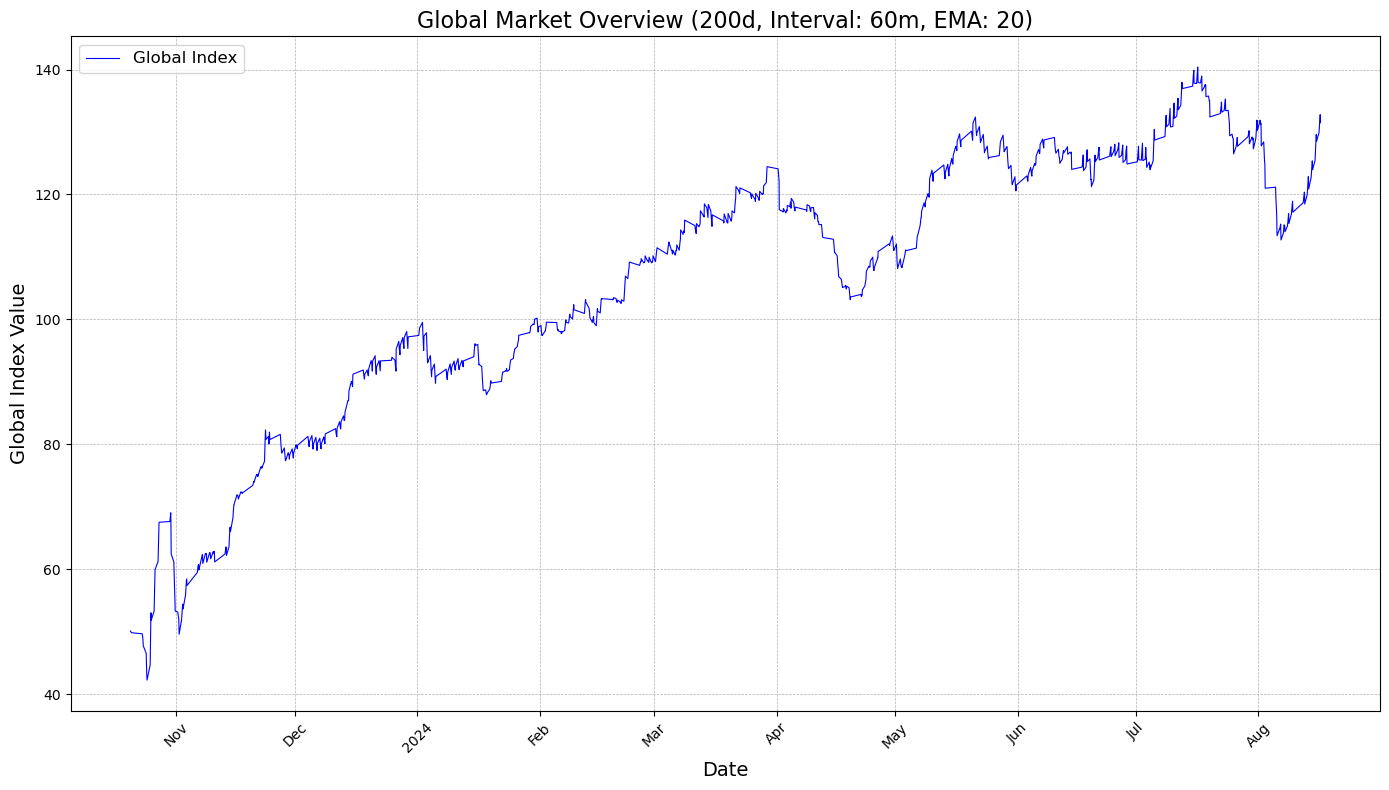

In [16]:
# Plotting
plt.figure(figsize=(14, 8))
plt.title(f'Global Market Overview ({period}, Interval: {interval}, EMA: {ema_span})', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Global Index Value', fontsize=14)

plt.plot(scaled_smoothed_global_index.index, scaled_smoothed_global_index, label='Global Index', color='blue', linewidth=0.8)

plt.legend(loc='upper left', fontsize=12)
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()